# Data

In [57]:
import numpy as np
from pathlib import Path


data_dir = Path("data")
imgs_dir = data_dir / "things-eeg2-imgs"
eeg_dir = data_dir / "things-eeg2-pre"


ex_data_path = "data/things-eeg2-pre/sub-01/preprocessed_eeg_training.npy"
ex_data = np.load(ex_data_path, allow_pickle=True).item()
ex_data.keys()

dict_keys(['preprocessed_eeg_data', 'ch_names', 'times'])

In [58]:
train_img_paths = [img_dir for concept_dir in sorted((imgs_dir / "training_images").iterdir()) for img_dir in sorted(concept_dir.iterdir())]
test_img_paths = [img_dir for concept_dir in sorted((imgs_dir / "test_images").iterdir()) for img_dir in sorted(concept_dir.iterdir())]

train_imgs_per_concept = 10
test_imgs_per_concept = 1

In [59]:
from typing import Literal

def idx_to_img_path(idx: int, split: Literal["train", "test"]) -> Path:
    if split == "train":
        paths = train_img_paths

    elif split == "test":
        paths = test_img_paths

    else:
        raise ValueError(f"Invalid split: {split}")
    
    return paths[idx]



print("0", idx_to_img_path(0, "train"))  # Aardvark 1
print("10", idx_to_img_path(10, "train"))  # Acabus 1
print("11", idx_to_img_path(11, "train"))  # Acabus 2

0 data/things-eeg2-imgs/training_images/00001_aardvark/aardvark_01b.jpg
10 data/things-eeg2-imgs/training_images/00002_abacus/abacus_01b.jpg
11 data/things-eeg2-imgs/training_images/00002_abacus/abacus_02s.jpg


## Image Data

Size: torch.Size([3, 500, 500])
Dtype: torch.uint8
Min Max: tensor(6, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


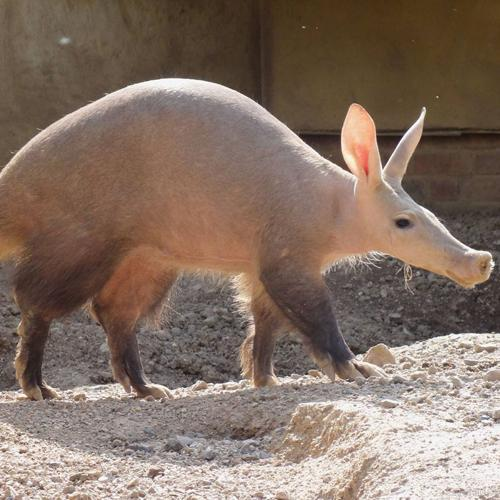

In [60]:
import torchvision
from torchvision.transforms import v2 as tv2
import matplotlib.pyplot as plt

def load_img(idx: int, split: Literal["train", "test"]):
    path = idx_to_img_path(idx, split)
    img = torchvision.io.decode_image(str(path))
    return img

img = load_img(0, "train")

print("Size:", img.size())
print("Dtype:", img.dtype)
print("Min", "Max:", img.min(), img.max())

tv2.functional.to_pil_image(img)

Size: torch.Size([3, 256, 256])
Dtype: torch.float32
Min Max: tensor(0.0431) tensor(1.)


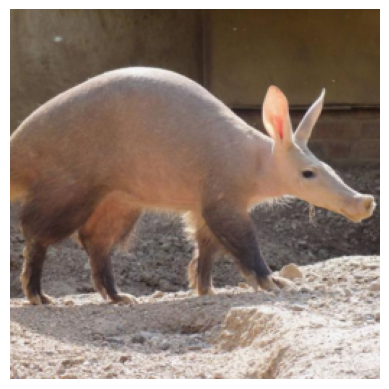

In [61]:
import torch


def preprocess_img(img: torch.Tensor) -> torch.Tensor:
    """Preprocess image for by resizing to 256, then normalizing to [0,1]."""

    img = tv2.functional.resize(img, [256])
    img_pp = img / 255.0
    return img_pp


img_pp = preprocess_img(img)
print("Size:", img_pp.size())
print("Dtype:", img_pp.dtype)
print("Min", "Max:", img_pp.min(), img_pp.max())

plt.imshow(img_pp.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

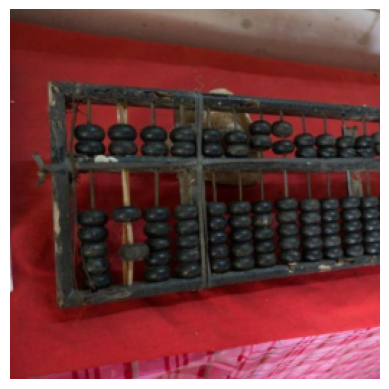

In [62]:
img2_pp = load_img(11, "train")
img2_pp = preprocess_img(img2_pp)
plt.imshow(img2_pp.permute(1, 2, 0).numpy())
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

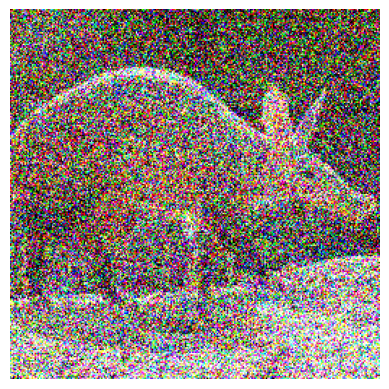

In [63]:
noisy_img_pp_05 = torch.clamp(img_pp + 0.5 * torch.randn_like(img_pp), 0, 1)
noisy_img_pp_005 = torch.clamp(img_pp + 0.05 * torch.randn_like(img_pp), 0, 1)
plt.imshow(noisy_img_pp_05.permute(1, 2, 0).numpy())
plt.axis("off")

In [64]:
from dreamsim.model import dreamsim


dreamsim_model, _ = dreamsim(dreamsim_type="synclr_vitb16")
dreamsim_model.requires_grad_(False)
dreamsim_model.eval()


Using cached ./models


/home/gasparyanartur/dev/brain-image-implementation/.venv/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


PeftModel(
  (base_model): LoraModel(
    (model): PerceptualModel(
      (extractor_list): ModuleList(
        (0): ViTExtractor(
          (model): VisionTransformer(
            (patch_embed): PatchEmbed(
              (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
            )
            (pos_drop): Dropout(p=0.0, inplace=False)
            (blocks): ModuleList(
              (0-11): 12 x Block(
                (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
                (attn): Attention(
                  (qkv): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=2304, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): L

In [65]:
sim_img_to_img2 = dreamsim_model(img_pp.unsqueeze(0).to(dreamsim_model.device), img2_pp.unsqueeze(0).to(dreamsim_model.device))
sim_img_to_noise_005 = dreamsim_model(img_pp.unsqueeze(0).to(dreamsim_model.device), noisy_img_pp_005.unsqueeze(0).to(dreamsim_model.device))
sim_img_to_noise_05 = dreamsim_model(img_pp.unsqueeze(0).to(dreamsim_model.device), noisy_img_pp_05.unsqueeze(0).to(dreamsim_model.device))

print("Dreamsim:")
print("\tSimilarity img to img2:", sim_img_to_img2.item())
print("\tSimilarity img to noise (0.05):", sim_img_to_noise_005.item())
print("\tSimilarity img to noise (0.5):", sim_img_to_noise_05.item())

Dreamsim:
	Similarity img to img2: 0.7843990325927734
	Similarity img to noise (0.05): 0.10495889186859131
	Similarity img to noise (0.5): 0.8359501361846924


In [66]:
aligned_synclr_model = dreamsim_model.base_model.model.extractor_list[0].model
aligned_synclr_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): lora.Linear(
          (base_layer): Linear(in_features=768, out_features=2304, bias=True)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default): Linear(in_features=768, out_features=16, bias=False)
          )
          (lora_B): ModuleDict(
            (default): Linear(in_features=16, out_features=2304, bias=False)
          )
          (lora_embedding_A): ParameterDict()
          (lora_embedding_B): ParameterDict()
          (lora_magnitude_vector): ModuleDict()
        )
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=T

In [67]:
from dreamsim.feature_extraction.load_synclr_as_dino import load_synclr_as_dino

synclr_model = load_synclr_as_dino(16)
synclr_model.requires_grad_(False)
synclr_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [68]:
def get_cosine_sim(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
    x1 = x1.flatten(start_dim=1)
    x2 = x2.flatten(start_dim=1)
    x1 = x1 / torch.norm(x1, dim=-1, keepdim=True)
    x2 = x2 / torch.norm(x2, dim=-1, keepdim=True)
    return (x1 @ x2.T).squeeze(0)

In [69]:
z1 = synclr_model(img_pp.unsqueeze(0))
z2 = synclr_model(img2_pp.unsqueeze(0))
zn005 = synclr_model(noisy_img_pp_005.unsqueeze(0))
zn05 = synclr_model(noisy_img_pp_05.unsqueeze(0))

sim_img_to_img2 = get_cosine_sim(z1, z2)
sim_img_to_noise_005 = get_cosine_sim(z1, zn005)
sim_img_to_noise_05 = get_cosine_sim(z1, zn05)

print("SimClr:")
print("\tSimilarity img to img2:", sim_img_to_img2.item())
print("\tSimilarity img to noise (0.05):", sim_img_to_noise_005.item())
print("\tSimilarity img to noise (0.5):", sim_img_to_noise_05.item())

SimClr:
	Similarity img to img2: 0.11319476366043091
	Similarity img to noise (0.05): 0.8490039706230164
	Similarity img to noise (0.5): 0.10909505188465118


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

z1 = aligned_synclr_model(img_pp.unsqueeze(0).to(device))
z2 = aligned_synclr_model(img2_pp.unsqueeze(0).to(device))
zn005 = aligned_synclr_model(noisy_img_pp_005.unsqueeze(0).to(device))
zn05 = aligned_synclr_model(noisy_img_pp_05.unsqueeze(0).to(device))

sim_img_to_img2 = get_cosine_sim(z1, z2)
sim_img_to_noise_005 = get_cosine_sim(z1, zn005)
sim_img_to_noise_05 = get_cosine_sim(z1, zn05)

print("Aligned SimClr:")
print("\tSimilarity img to img2:", sim_img_to_img2.item())
print("\tSimilarity img to noise (0.05):", sim_img_to_noise_005.item())
print("\tSimilarity img to noise (0.5):", sim_img_to_noise_05.item())

Aligned SimClr:
	Similarity img to img2: 0.2675003111362457
	Similarity img to noise (0.05): 0.9673334956169128
	Similarity img to noise (0.5): 0.30507606267929077


In [72]:
import tqdm

GEN_EMBEDDINGS = False


def gen_embeddings(
    model: torch.nn.Module,
    img_paths: list[Path],
    split: Literal["train", "test"],
    batch_size: int = 32,
    device: torch.device = device,
) -> np.ndarray:
    """Generate embeddings for a given split of images."""
    model.eval()
    model.to(device)
    embeddings = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, len(img_paths), batch_size)):
            imgs = [load_img(j, split=split) for j in range(i, min(i + batch_size, len(img_paths)))]
            imgs = [preprocess_img(img).unsqueeze(0) for img in imgs]
            imgs = torch.cat(imgs, dim=0).to(device)
            emb = model(imgs)
            embeddings.append(emb.cpu().numpy())
    return np.concatenate(embeddings, axis=0)


embed_dir = data_dir / "things-eeg2-imgs-embed"
for model, name in [
    (synclr_model, "synclr"),
    (aligned_synclr_model, "aligned_synclr"),
]:
    if GEN_EMBEDDINGS:
        print(f"Generating {name} embeddings...")

        train_embeddings = gen_embeddings(model, train_img_paths, split="train", batch_size=512)
        np.save(f"{embed_dir / name}/train_embeddings.npy", train_embeddings)

        test_embeddings = gen_embeddings(model, test_img_paths, split="test", batch_size=512)
        np.save(f"{embed_dir / name}/test_embeddings.npy", test_embeddings)

    else:
        print("Loading embeddings...")

        train_embeddings = np.load(f"{embed_dir / name}/train_embeddings.npy")
        test_embeddings = np.load(f"{embed_dir / name}/test_embeddings.npy")


Loading embeddings...
Loading embeddings...


## EEG Data

In [73]:
channel_names = ex_data["ch_names"]
print(f"Channel names: {', '.join(channel_names)}")

eeg_data = ex_data["preprocessed_eeg_data"]
print("EEG data: ")
print(f"\tShape: {eeg_data.shape}")
print(f"\tData type: {eeg_data.dtype}")
print(f"\tMaximum value: {np.max(eeg_data)}")
print(f"\tMinimum value: {np.min(eeg_data)}")
print(f"\tMean value: {np.mean(eeg_data)}")
print(f"\tStandard deviation: {np.std(eeg_data)}")

times = ex_data["times"]
print(f"Times: {times}")

Channel names: Pz, P3, P7, O1, Oz, O2, P4, P8, P1, P5, PO7, PO3, POz, PO4, PO8, P6, P2
EEG data: 
	Shape: (16540, 4, 17, 100)
	Data type: float64
	Maximum value: 85.14618876376869
	Minimum value: -328.7584416400444
	Mean value: -0.03503607400085798
	Standard deviation: 0.8400870602744809
Times: [-0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09
 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03
  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15
  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27
  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39
  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  0.5   0.51
  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63
  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71  0.72  0.73  0.74  0.75
  0.76  0.77  0.78  0.79]


In [74]:
def preprocess_eeg_data(eeg_data):
    """Preprocess the EEG data by averaging over the number of repetitions.

    Args:
        eeg_data (numpy.ndarray): The EEG data to preprocess. <concepts, repetitions, channels, timesteps>

    Returns:
        numpy.ndarray: The preprocessed EEG data. <concepts, channels, timesteps>
    """
    # Average over the number of repetitions
    preprocessed_data = np.mean(eeg_data, axis=1)
    return preprocessed_data

eeg_data_pp = preprocess_eeg_data(eeg_data)
eeg_data_pp.shape

(16540, 17, 100)

In [104]:
def load_eeg_data(eeg_path: Path):
    """Load EEG data from a given path."""
    eeg_data = np.load(eeg_path, allow_pickle=True).item()
    return (
        preprocess_eeg_data(eeg_data["preprocessed_eeg_data"]),
        eeg_data["times"],
        eeg_data["ch_names"],
    )


def load_all_eeg_data(eeg_paths: list[Path]) -> tuple[torch.Tensor, torch.Tensor, list[str]]:
    all_eeg_data = []
    all_times = None
    all_ch_names = []

    for eeg_path in eeg_paths:
        eeg_data, times, ch_names = load_eeg_data(eeg_path)
        eeg_data = preprocess_eeg_data(eeg_data)
    
        all_eeg_data.append(torch.from_numpy(eeg_data))
        
        if all_times is None:
            all_times = torch.tensor(times)

        if not all_ch_names:
            all_ch_names = ch_names

    if all_times is None:
        all_times = torch.tensor([])

    return torch.concat(all_eeg_data), all_times, all_ch_names


## Unified Data

In [ ]:
from pydantic import BaseModel
from torch.utils.data import Dataset


class EEGDatasetConfig(BaseModel):
    data_path: Path = Path("data")
    imgs_dir: str = "things-eeg2-imgs"
    eeg_dir: str = "things-eeg2-pre"
    imgs_latent_dir: str = "things-eeg2-imgs-embed"
    train_imgs_per_concept: int = 10
    test_imgs_per_concept: int = 1
    subs: list[int] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


class EEGDataset(Dataset):
    def __init__(self, config: EEGDatasetConfig, split: Literal["train", "test"], model_name: str = "synclr"):
        self.config = config
        self.split = split
        self.model_name = model_name
        self.imgs_per_concepts = self.config.train_imgs_per_concept if split == "train" else self.config.test_imgs_per_concept
        
        if split == "train":
            img_subdir = "training_images"
            img_embed_name = "train_embeddings"
            eeg_name = "preprocessed_eeg_training"

        else:
            img_subdir = "test_images"
            img_embed_name = "test_embeddings"
            eeg_name = "preprocessed_eeg_test"

        self.img_paths = [img_dir for concept_dir in sorted((self.config.data_path / self.config.imgs_dir / img_subdir).iterdir()) for img_dir in sorted(concept_dir.iterdir())]
        self.img_latents = torch.from_numpy(np.load(self.config.data_path / f"{self.config.imgs_latent_dir}/{model_name}/{img_embed_name}.npy"))


        self.eeg_data_paths = [
            self.config.data_path / self.config.eeg_dir / f"sub-{sub:02}" / f"{eeg_name}.npy"
            for sub in self.config.subs
        ]
        self.eeg_data, self.times, self.ch_names = load_all_eeg_data(self.eeg_data_paths)

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx: int):
        img_idx = idx % (len(self.img_paths))    # EEG has stacked over subs, so we need to find the right sample within the sub
        
        img_path = self.img_paths[img_idx]
        img_latent = self.img_latents[img_idx]

        eeg_data = self.eeg_data[idx]

        return {
            "img_path": img_path,
            "img_latent": img_latent,
            "eeg_data": eeg_data,
        }

In [120]:
config = EEGDatasetConfig()
train_dataset = EEGDataset(config, split="train")
test_dataset = EEGDataset(config, split="test")

# Model